In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

%matplotlib inline 

In [2]:
# import all pyphysio classes and methods
import pyphysio as ph

Please cite:
Bizzego et al. (2019) 'pyphysio: A physiological signal processing library for data science approaches in physiology', SoftwareX


In [3]:
# import data and creating a signal
df_BVP = pd.read_csv('BVP_pp12.csv', header=None)


In [4]:
#count rows 
n_of_rows = df_BVP.count()
print(n_of_rows)

0    244728
dtype: int64


In [5]:
#count n of rows to get time of recording (s) 
n_of_rows = df_BVP.count()
print(n_of_rows)
#walk time in seconds 
walk_time_seconds = n_of_rows/64
print(walk_time_seconds)
#walk time in minutes
walk_time_minutes = walk_time_seconds/60
print(walk_time_minutes)


0    244728
dtype: int64
0    3823.875
dtype: float64
0    63.73125
dtype: float64


In [6]:
#create BVP signal 
fsamp = 64  #64 Hz 
t_start = 0

ecg = ph.EvenlySignal(values = df_BVP, sampling_freq = fsamp, signal_type = 'ecg')

In [7]:
print(ecg.get_start_time())

0


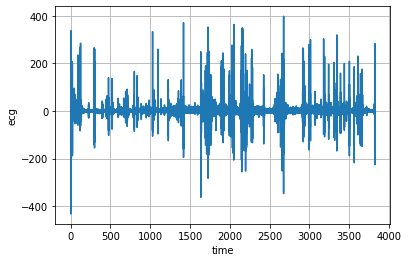

In [8]:
ecg.plot()

In [9]:
ibi = ph.BeatFromECG()(ecg)

In [10]:
ibi.get_duration() #seconds 

3823.875

In [11]:
# create label
label = np.zeros(3823)
label[0:600] =1
label[600:3823] = 2

label = ph.EvenlySignal(label, sampling_freq = 1, signal_type = 'label') 
#sampling_freq here is not intended as real sampfeq, only the distance between one point and the other (e.g. 10 = 10 units between 'begin' & 'end')

In [12]:
# (optional) IIR filtering : remove high frequency noise
#ecg = ph.IIRFilter(fp=45, fs = 50, ftype='ellip')(ecg)

In [13]:
# normalization : normalize data
ecg = ph.Normalize(norm_method='standard')(ecg)

In [14]:
# resampling : increase the sampling frequency by cubic interpolation
ecg = ecg.resample(fout=4096, kind='cubic')
fsamp = 4096

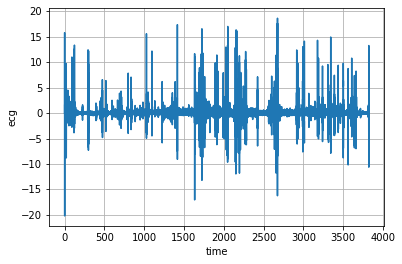

In [15]:
ecg.plot()

In [16]:
ibi = ph.BeatFromECG()(ecg)

In [17]:
ibi.get_duration()


3823.875

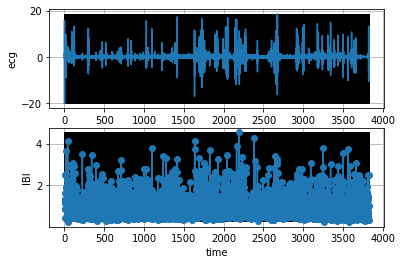

In [18]:
# check results so far
ax1 = plt.subplot(211)
ecg.plot()
plt.vlines(ibi.get_times(), np.min(ecg), np.max(ecg))

plt.subplot(212, sharex = ax1)
ibi.plot('o-')
plt.vlines(ibi.get_times(), np.min(ibi), np.max(ibi))
plt.show()

In [19]:
### physiological indicators 

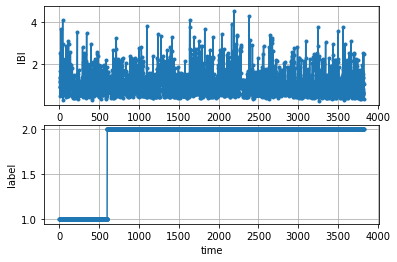

In [20]:
# check label
ax1 = plt.subplot(211)
ibi.plot('.-')

plt.subplot(212, sharex = ax1)
label.plot('.-')
plt.show()

In [21]:
# define a list of indicators we want to compute
hrv_indicators = [ph.Mean(name='RRmean'), ph.StDev(name='RRstd'), ph.RMSSD(name='rmsSD')]

In [22]:
#fixed length windowing
fixed_length = ph.FixedSegments(step = 60, width = 60, labels = label)

indicators, col_names = ph.fmap(fixed_length, hrv_indicators, ibi)

In [23]:
# extract column with the labels for each window
label_w = indicators[:, np.where(col_names == 'label')[0]]

# extract column with the RRmean values computed from each window
rrmean_w = indicators[:, np.where(col_names == 'RRmean')[0]]

rrmean_image1 = rrmean_w[np.where(label_w==1)[0]].ravel()
rrmean_image2 = rrmean_w[np.where(label_w==2)[0]].ravel()

{'whiskers': [<matplotlib.lines.Line2D at 0x1c1d18d210>,
 'caps': [<matplotlib.lines.Line2D at 0x1c1d18dc50>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c1d1845d0>,
 'medians': [<matplotlib.lines.Line2D at 0x1c1d1936d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1c1d193bd0>,
 'means': []}

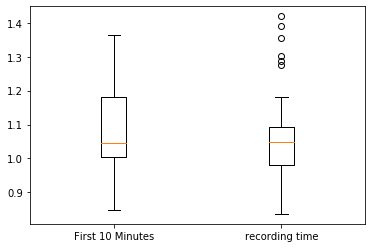

In [24]:
## create a box and whisker plot to compare the distibution of the RRmean indicator
plt.boxplot([rrmean_image1, rrmean_image2],
            labels=['First 10 Minutes', 'recording time'])

In [25]:
HRV_FD = ph.preset_hrv_fd() #frequency domain HRV indicators
print(HRV_FD)

print(HRV_FD[0].get())

[IBI_VLF_Pow, IBI_LF_Pow, IBI_HF_Pow, IBI_Total_Pow]
{'freq_min': 1e-05, 'freq_max': 0.04, 'method': 'ar', 'interp_freq': 4, 'name': 'IBI_VLF_Pow'}


In [26]:
FD_HRV_ind, col_names = ph.fmap(fixed_length, ph.preset_hrv_fd(), ibi.resample(4))

In [27]:
import pandas as pd

# create a pandas dataframe
FD_HRV_pp12_df = pd.DataFrame(FD_HRV_ind, columns=col_names)

FD_HRV_pp12_df

,begin,end,label,IBI_VLF_Pow,IBI_LF_Pow,IBI_HF_Pow,IBI_Total_Pow
0,1.232422,61.232422,1.0,363.369739,988.386445,852.104862,2808.469596
1,61.232422,121.232422,1.0,131.997933,467.649561,835.201670,2182.155596
2,121.232422,181.232422,1.0,144.971241,446.804575,753.411991,2097.774915
3,181.232422,241.232422,1.0,198.961360,655.238789,792.507034,2370.138533
4,241.232422,301.232422,1.0,346.494085,515.680345,718.007302,2364.055991
...,...,...,...,...,...,...,...
57,3481.232422,3541.232422,2.0,486.901064,1026.935036,807.874486,3010.813542
58,3541.232422,3601.232422,2.0,289.341709,898.404623,685.212411,2571.108377
59,3601.232422,3661.232422,2.0,180.821577,555.501136,614.997988,1961.300686
60,3661.232422,3721.232422,2.0,194.983255,536.927549,643.631480,2060.109962


In [28]:
#save data 
FD_HRV_pp12_df.to_csv('FD_HRV_pp12.csv')